# Trajectory Data Mining <a  id="top"></a>

**Context**: Given a dataset of several persons' travel history containing variables `latitude`, `longitude` and `time`, how do we perform data preprocessing, data analysis and data mining?

- [Reading GeoLife Dataset](#GeoLife)
- [Noise filtering](#filtering)
- [Stay point detection](#SPDA)
- [Clustering of stay points](#SPDA_Clustering)
- [Longest Common Subsequence problem](#LCS)

In [1]:
import numpy as np
import pandas as pd
import numba

import folium
from folium import plugins

from sklearn.cluster import DBSCAN

import time
import random
from statistics import mean, median
from math import radians, cos, sin, asin, sqrt
import os

In [2]:
%load_ext Cython

I've implemented some functions in a python file `auxiliary_functions.py`, I chose to keep the tested and proved algorithms there to prevent this notebook from being too lengthy.

In [3]:
from auxiliary_functions import *

In [4]:
GEOLIFE_DATA_PATH =r"C:\Users\Tay\Documents\GitHub\Trajectory-Data-Mining\Geolife Trajectories 1.3\Data"

In [5]:
users = os.listdir(GEOLIFE_DATA_PATH)
print("Number of users in Geolife dataset: " + str(len(users)))

Number of users in Geolife dataset: 182


# Importing trajectories from Geolife dataset <a id="GeoLife"></a>
Some things I changed:
- According to the User Guide from Microsoft, the 3rd column is all set to 0 and the 3rd last column is the number of days that has passed since 12/30/1899, both not useful to me.
- Merged the `date` and `time` together and cast the datetime type onto them.

Note
- `time` is in GMT+0 for all their datetime data.
- `alt` = -777 means that the altitude isn't available.

[Back to top](#top)

In [6]:
def readUserTraj(path_to_user):
    '''
    :param path_to_user: a path to the user's dataset according to the Geolife dataset file system
    :return: a dataframe containing all of the user's trajectories
    '''
    trajs = os.listdir(path_to_user + r"\Trajectory")
    col_names = ["lat", "lon", "alt", "date", "time"]
    userTraj = pd.DataFrame(columns=["lat", "lon", "alt", "time"])
    
    for i in range(len(trajs)):
        TRAJ_PATH = path_to_user + r"\Trajectory" + r"\\" + trajs[i]
        traj = pd.read_csv(TRAJ_PATH, skiprows=6, header=None, usecols=[0,1,3,5,6], names=col_names)
        
        traj["full_date"] = traj["date"].str.cat(traj["time"], sep=" ")
        traj["full_date"] = traj["full_date"].apply(lambda x: pd.to_datetime(x))

        traj = traj.drop(columns = ["date", "time"])
        traj = traj.rename(columns = {"full_date": "time"})
        
        userTraj = userTraj.append(traj)
        userTraj = userTraj.reset_index(drop=True)
    
    return userTraj

In [7]:
%%time
%%prun
trajDataFrames = [readUserTraj(GEOLIFE_DATA_PATH + r"\\" + users[i]) for i in range(5)]

 Wall time: 5min 13s


Let's check the spatial density and temporal density of the datasets of each user

In [23]:
def getSummaryStatistic(df_list):
    '''
    assumptions: the dataframes are already sorted by increasing time
    
    :param df: a list of dataframes, each dataframe should have the variable `time`
    :return summary_df: a dataframe containing summary statistics about `df`
    '''
    summary_df = pd.DataFrame(columns=["No. of datapoints", "Sampling rate 25 pct (secs)", "Sampling rate 75 pct (secs)",
                                       "Distance 25 pct (m)", "Distance 75 pct (m)"])
    
    for i in range(len(df_list)):
        df = df_list[i]
        if len(df) == 0:
            continue
        timeInt = (df.time[1:].reset_index(drop=True) - df.time[:-1]).astype('timedelta64[s]')
        dist_df = pd.concat([df.lon[:-1].reset_index(drop=True),
                             df.lat[:-1].reset_index(drop=True),
                             df.lon[1:].reset_index(drop=True),
                             df.lat[1:].reset_index(drop=True)], axis=1)
        dist_numpy = dist_df.to_numpy()
        distInt = np.apply_along_axis(lambda x: haversine(x[0], x[1], x[2], x[3]), 1, dist_numpy)
        summary_df.loc[i,:] = [len(df), np.percentile(timeInt, 25), np.percentile(timeInt, 75),\
                               np.percentile(distInt, 25), np.percentile(distInt, 75)]
    
    return summary_df

In [26]:
%%time
%%prun
summary_df = getSummaryStatistic(trajDataFrames)

 Wall time: 12.1 s


In [10]:
summary_df

,No. of datapoints,Sampling rate 25 pct (secs),Sampling rate 75 pct (secs),Distance 25 pct (m),Distance 75 pct (m)
0,173870,5,5,2.12833,18.2196
1,108607,2,5,1.47338,12.3708
2,248217,2,5,3.67249,10.0366
3,485226,5,5,1.69196,19.3644
4,439397,5,5,2.98055,20.048


In [11]:
trajDataFrames[0]

,lat,lon,alt,time
0,39.984702,116.318417,492,2008-10-23 02:53:04
1,39.984683,116.318450,492,2008-10-23 02:53:10
2,39.984686,116.318417,492,2008-10-23 02:53:15
3,39.984688,116.318385,492,2008-10-23 02:53:20
4,39.984655,116.318263,492,2008-10-23 02:53:25
...,...,...,...,...
173865,40.000403,116.327255,149,2009-07-05 07:44:55
173866,40.000433,116.327209,150,2009-07-05 07:45:00
173867,40.000443,116.327186,150,2009-07-05 07:45:05
173868,40.000522,116.327132,149,2009-07-05 07:45:10


In [12]:
trajDataFrames[1]

,lat,lon,alt,time
0,39.984094,116.319236,492,2008-10-23 05:53:05
1,39.984198,116.319322,492,2008-10-23 05:53:06
2,39.984224,116.319402,492,2008-10-23 05:53:11
3,39.984211,116.319389,492,2008-10-23 05:53:16
4,39.984217,116.319422,491,2008-10-23 05:53:21
...,...,...,...,...
108602,39.977969,116.326651,311,2008-12-15 00:30:58
108603,39.977946,116.326653,310,2008-12-15 00:31:03
108604,39.977897,116.326624,310,2008-12-15 00:31:08
108605,39.977882,116.326626,310,2008-12-15 00:31:13


In [13]:
trajDataFrames[2]

,lat,lon,alt,time
0,39.927938,116.338967,492,2008-10-23 12:45:23
1,39.927527,116.338899,492,2008-10-23 12:45:24
2,39.926516,116.338048,401,2008-10-23 12:45:54
3,39.926496,116.338094,380,2008-10-23 12:45:59
4,39.926498,116.338140,365,2008-10-23 12:46:04
...,...,...,...,...
248212,39.989629,116.222151,118,2009-03-22 08:13:23
248213,39.989583,116.222194,114,2009-03-22 08:13:28
248214,39.989542,116.222221,112,2009-03-22 08:13:30
248215,39.989514,116.222292,110,2009-03-22 08:13:34


In [14]:
trajDataFrames[3]

,lat,lon,alt,time
0,39.999844,116.326752,492,2008-10-23 17:58:54
1,39.999876,116.326708,492,2008-10-23 17:58:59
2,39.999915,116.326672,492,2008-10-23 17:59:04
3,40.000059,116.327140,142,2008-10-23 17:59:09
4,40.000039,116.327172,132,2008-10-23 17:59:14
...,...,...,...,...
485221,40.000403,116.327255,149,2009-07-05 07:44:55
485222,40.000433,116.327209,150,2009-07-05 07:45:00
485223,40.000443,116.327186,150,2009-07-05 07:45:05
485224,40.000522,116.327132,149,2009-07-05 07:45:10


In [15]:
trajDataFrames[4]

,lat,lon,alt,time
0,39.999974,116.327149,143,2008-10-23 17:58:52
1,40.000011,116.327161,126,2008-10-23 17:58:58
2,40.000008,116.327135,135,2008-10-23 17:59:03
3,40.000016,116.327126,135,2008-10-23 17:59:08
4,40.000003,116.327098,141,2008-10-23 17:59:13
...,...,...,...,...
439392,39.999916,116.327657,605,2009-07-29 06:15:51
439393,39.999934,116.327693,610,2009-07-29 06:15:56
439394,39.999803,116.327442,573,2009-07-29 06:16:01
439395,39.999790,116.327409,572,2009-07-29 06:16:06


Plotting of the trajectory for user 000

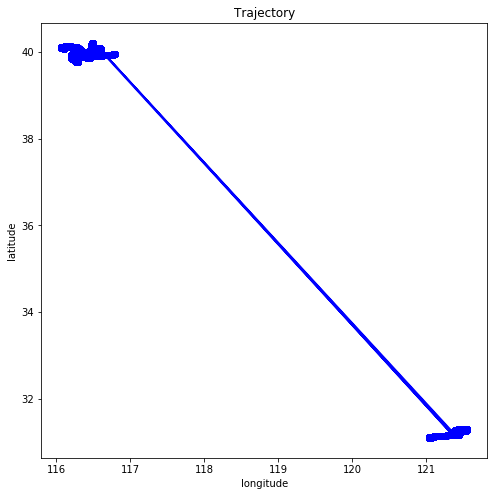

In [16]:
plot_traj(trajDataFrames[0])

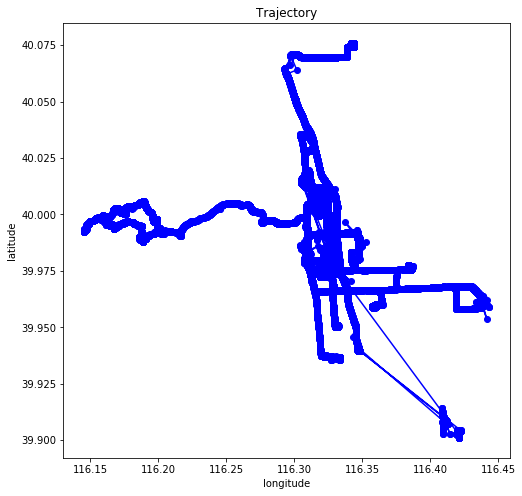

In [17]:
plot_traj(trajDataFrames[1])

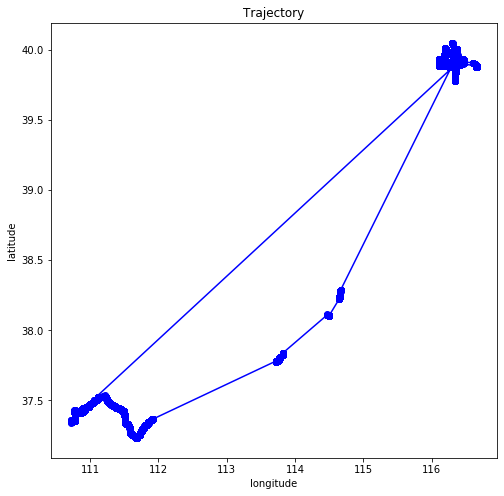

In [18]:
plot_traj(trajDataFrames[2])

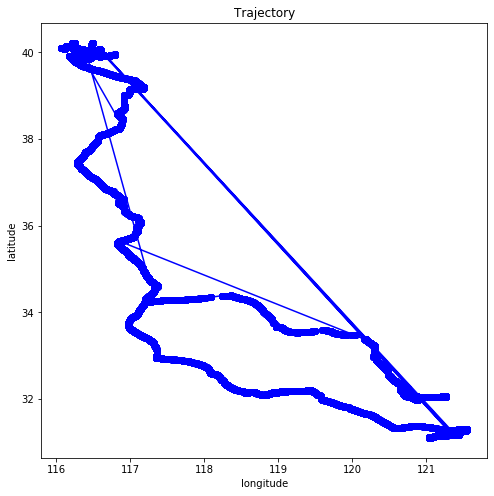

In [19]:
plot_traj(trajDataFrames[3])

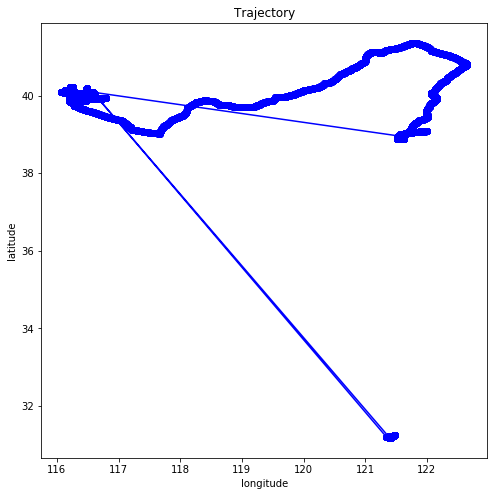

In [20]:
plot_traj(trajDataFrames[4])

In [ ]:
# m = folium.Map([40, 116.5], zoom_start=10)

# for index, row in traj000.iterrows():
#     folium.CircleMarker([row['lat'], row['lon']],
#                             radius=0.001,
#                             fill_color="#3db7e4", # divvy color
#                            ).add_to(m)

# # plot heatmap
# # m.add_child(plugins.HeatMap(valid_df[['y', 'x']].to_numpy(), radius=15))

# m

# Noise Filtering with mean and median filter <a id="filtering"></a>

The travel history of the users might not be entirely accurate, for example the geolocation of the user might be bouncing to and from different locations due to signalling error. The procedure to remove such noise is called **noise filtering**.

[Back to top](#top)

In [21]:
traj = genTrajectory(NUM_POINTS=100)
traj.head()

,lon,lat,time,inacc_radius
0,101.354458,1.712698,340.410672,63.489769
1,107.772013,3.998433,172.383462,54.618867
2,102.140705,1.173803,281.055156,65.598080
3,107.827054,2.384659,320.704720,0.991137
4,107.700510,1.029790,405.419233,97.832439


## Comparing the performance of mean filter and median filter

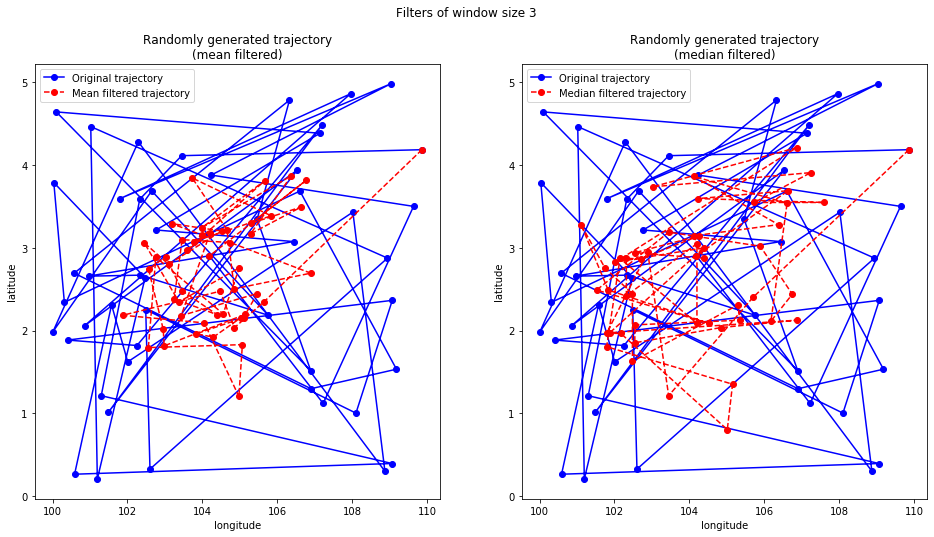

In [22]:
traj = genTrajectory(NUM_POINTS=50)

mean_traj = getFilteredTraj(traj, filter_type="mean")
median_traj = getFilteredTraj(traj, filter_type="median")

plot_filtered_traj(traj, mean_traj, median_traj, window_size=3)

# Stay Point Detection Algorithm <a id="SPDA"></a>

In the [paper](https://github.com/tyqiangz/Trajectory-Data-Mining/blob/master/Useful%20Research%20Materials/Stay%20Point%20Analysis%20in%20Automatic%20Identification%20System%20Trajectory%20Data.pdf), the authors introduced the Stay Point Detection algorithm to identify locations where the user have stayed for awhile. 

The parameters of SPDA is set as `distThres` = 200 (metres), `timeThres` = 30\*60 (seconds), `minpoints` = 50, in accordance to what the authors proposed.

[Back to top](#top)

Note that the first 5 users have 1.5 million datapoints combined, the following algorithm runs in linear time and takes 45 mins to find the stay points for 173,870 points.

In [30]:
def SPDA_fast(traj, distThres, timeThres, minPoints):
    # reorder the columns to have columns 'time', 'lon', 'lat' first
    cols = list(traj.columns.values)
    features = ['time', 'lon', 'lat']
    for feature in features:
        cols.remove(feature)
    reOrderedFeatures = ['time', 'lon', 'lat'] + cols
    
    # convert dataframe to numpy array
    traj_numpy = traj[reOrderedFeatures].to_numpy()
    
    return SPDA_faster(traj_numpy, distThres, timeThres, minPoints)

In [33]:
%%cython
def SPDA_faster(traj_numpy, distThres, timeThres, minPoints):
    '''
    :param traj: a numpy ndarray where first 3 columns refer to variables ['time', 'lon', 'lat']
    :param distThres: a threshold of the distance (in metres)
    :param timeThres: a threshold of the time (in seconds)
    :param minPoints: the minimum no. of points required in a stay-point region
    :output: a set of stay-points
    
    '''
    def distance(pointA, pointB):
        '''
        :param pointA: a point with lat and lon variables
        :param pointB: a point with lat and lon variables
        :return: the distance between pointA and pointB calculated by Haversine formula
        '''
        return haversine(pointA[1], pointA[2], pointB[1], pointB[2])
    
    def getCentroid(points, centroid_type):
        '''
        :param points: a list of points with lat and lon variables
        :param centroid_type: "median" or "mean"
        :return: the centre of the list of points, calculated by centroid_type function
        '''
#         print("centroid points:\n", points)
        if centroid_type == "median":
            return [median(points[:,1]), median(points[:,2])]
        elif centroid_type == "mean":
            return [mean(points[:,1]), mean(points[:,2])]
        
    i = 0
    pointNum = len(traj_numpy)
    stayPoints = []
    
    while i < pointNum:
        j = i+1
        token = 0
        while j < pointNum:
#             print("Analysing point: " + str(j) + " "*5, "\r", end="")
            dist = distance(traj_numpy[j,:], traj_numpy[i,:])
            if dist > distThres:
                timeDiff = (traj_numpy[j,0] - traj_numpy[i,0]).total_seconds()
                if (timeDiff > timeThres) and (j-i >= minPoints):
                    centroid = getCentroid(traj_numpy[i:(j-1),:], "median")
                    print(centroid)
                    stayPoints.append(
                        stayPoint(
                            arrivalTime = traj_numpy[i,0], 
                            departTime = traj_numpy[j,0], 
                            startIndex = i,
                            endIndex = j,
                            location = centroid
                        )
                    )
                    
                    i = j
                    token = 1
                break
            j += 1
            
        if token != 1:
            i += 1
            
    return stayPoints


Error compiling Cython file:
------------------------------------------------------------
...
                timeDiff = (traj_numpy[j,0] - traj_numpy[i,0]).total_seconds()
                if (timeDiff > timeThres) and (j-i >= minPoints):
                    centroid = getCentroid(traj_numpy[i:(j-1),:], "median")
                    print(centroid)
                    stayPoints.append(
                        stayPoint(
                       ^
------------------------------------------------------------

C:\Users\Tay\.ipython\cython\_cython_magic_fb75f97de4aabeb856e123a1a1907530.pyx:46:24: undeclared name not builtin: stayPoint

Error compiling Cython file:
------------------------------------------------------------
...
        '''
        :param pointA: a point with lat and lon variables
        :param pointB: a point with lat and lon variables
        :return: the distance between pointA and pointB calculated by Haversine formula
        '''
        return haversine(pointA[1], po

In [ ]:
%%time
%%prun
stayPointsList = [SPDA(trajDataFrames[i].iloc[:5000,:], distThres=200, timeThres=30*60, minPoints=50)
                  for i in range(1)]

In [ ]:
len(stayPointsList)

In [ ]:
for point in stayPointsList[0]:
    point.toString()

In [ ]:
%%time
%%prun
stayPointsList_fast = [SPDA_fast(trajDataFrames[i].iloc[:5000,:], distThres=200, timeThres=30*60, minPoints=50)
                  for i in range(1)]

In [ ]:
len(stayPointsList_fast)

In [ ]:
for point in stayPointsList_fast[0]:
    point.toString()

In [ ]:
for i in range(len(stayPointsList)):
    print("Number of staypoints for user 00" + str(i) + ": " + str(len(stayPointsList[i])))

Function to calculate the distance from a given point to anearest point in a dataset of point.

In [ ]:
def getShortestDist(df, lon, lat):
    '''
    :param df: a dataframe with variables `lat` and `lon` variables
    :param lon: longitude of a point
    :param lat: latitude of a point
    :return: the shortest distance from the point (`lon`, `lat`) to any point in `df`
    '''
    return min(df[["lon","lat"]].apply(lambda x: haversine(x[0], x[1], lon, lat), axis=1))

**Plot each user's stay points and all distinct points**

Looks like most people were from Tsinghua University and occasionally travel to Shanghai.

In [ ]:
stayPoints000Map = folium.Map([40, 116.5], zoom_start=6)

for i in range(len(trajDataFrames[0].iloc[::15,:])):
    folium.CircleMarker([trajDataFrames[0].loc[15*i,"lat"], trajDataFrames[0].loc[15*i,"lon"]],
                            radius=1,
                            color="black",
                           ).add_to(stayPoints000Map)
    
for stayPoint in stayPointsList[0]:
    folium.CircleMarker([stayPoint.location[1], stayPoint.location[0]],
                            radius=10,
                            color="#3db7e4", # divvy color
                           ).add_to(stayPoints000Map)
plugins.Fullscreen().add_to(stayPoints000Map)

stayPoints000Map

In [ ]:
getShortestDist(trajDataFrames[0], stayPointsList[0][0].location[0], stayPointsList[0][0].location[1])

In [ ]:
stayPointsList[0][0].location

Plotting all the staypoints in 1 map

In [ ]:
stayPointsMap = folium.Map([40, 116.5], zoom_start=5)

colors = ["red", "blue", "green", "orange", "gray"]

for i in range(len(stayPointsList)):
    for stayPoint in stayPointsList[i]:
        folium.CircleMarker([stayPoint.location[1], stayPoint.location[0]],
                                radius=10,
                                color=colors[i],
                                fill_color=colors[i],
                               ).add_to(stayPointsMap)

stayPointsMap

## Clustering the stay points <a id="SPDA_Clustering"></a>

Here we use DBSCAN to do clustering, we experiment with some values of `eps`.

[Back to top](#top)

First we collect all the stay points in a dataframe for easier data processing.

In [ ]:
stayPoints_df = pd.DataFrame(columns=["UserID", "lat", "lon", "arrivalTime", "departTime", 
                                      "startIndex", "endIndex","ClusterID"])

for i in range(len(stayPointsList)):
    for j in range(len(stayPointsList[i])):
        point = stayPointsList[i][j]
        stayPoints_df.loc[stayPoints_df.shape[0], :] = [i, point.location[1], point.location[0], 
                                                         point.arrivalTime, point.departTime,
                                                         point.startIndex, point.endIndex, np.nan]

In [ ]:
stayPoints_df

Let's check how much the `lat` and `lon` vary.

In [ ]:
min(stayPoints_df.lat), max(stayPoints_df.lat)

In [ ]:
min(stayPoints_df.lon), max(stayPoints_df.lon)

All the stay points are mainly within Tsinghua university so the (`lat`, `lon`) values are only within 0.5 degrees of each other. We try a few values and plot to see if it makes sense.

Note: DBSCAN labels outliers with a label = `-1`, I don't plot the outliers.

In [ ]:
clustering = DBSCAN(eps=0.005, min_samples=3).fit(stayPoints_df[["lat", "lon"]])
stayPoints_df.ClusterID =  clustering.labels_
print("Number of clusters: " + str(len(stayPoints_df.ClusterID.unique())-1))

In [ ]:
stayPointClustersMap = folium.Map([40, 116.5], zoom_start=10)

colors = ["red", "blue", "green", "orange", "gray", "pink"]

for i in stayPoints_df.ClusterID.unique():
    if i == -1:
        continue
    temp_df = stayPoints_df.loc[stayPoints_df.ClusterID == i, :]
    temp_df = temp_df.reset_index(drop=True)
    for j in range(temp_df.shape[0]):
        folium.CircleMarker([temp_df.lat[j], temp_df.lon[j]],
                                radius=10,
                                color=colors[i],
                                fill_color=colors[i],
                               ).add_to(stayPointClustersMap)

stayPointClustersMap

In [ ]:
clustering = DBSCAN(eps=0.002, min_samples=3).fit(stayPoints_df[["lat", "lon"]])
stayPoints_df.ClusterID =  clustering.labels_
print("Number of clusters: " + str(len(stayPoints_df.ClusterID.unique()) - 1))

In [ ]:
stayPointClustersMap = folium.Map([40, 116.5], zoom_start=10)

colors = ['red', 'blue', 'green', 'purple', 'orange', 
          'pink', 'black', 'gray', 'darkred', 'darkblue', 
          'darkgreen', 'darkpurple', 'lightblue', 'lightgreen']

for i in stayPoints_df.ClusterID.unique():
    if i == -1:
        continue
    temp_df = stayPoints_df.loc[stayPoints_df.ClusterID == i, :]
    temp_df = temp_df.reset_index(drop=True)
    for j in range(temp_df.shape[0]):
        folium.CircleMarker([temp_df.lat[j], temp_df.lon[j]],
                                radius=10,
                                color=colors[i],
                                fill_color=colors[i],
                               ).add_to(stayPointClustersMap)

stayPointClustersMap

In [ ]:
clustering = DBSCAN(eps=0.0025, min_samples=3).fit(stayPoints_df[["lat", "lon"]])
stayPoints_df.ClusterID =  clustering.labels_
print("Number of clusters: " + str(len(stayPoints_df.ClusterID.unique()) - 1))

In [ ]:
stayPointClustersMap = folium.Map([40, 116.5], zoom_start=10)

colors = ['red', 'blue', 'green', 'purple', 'orange', 
          'pink', 'black', 'gray', 'darkred', 'darkblue', 
          'darkgreen', 'darkpurple', 'lightblue', 'lightgreen']

for i in stayPoints_df.ClusterID.unique():
    if i == -1:
        continue
    temp_df = stayPoints_df.loc[stayPoints_df.ClusterID == i, :]
    temp_df = temp_df.reset_index(drop=True)
    for j in range(temp_df.shape[0]):
        folium.CircleMarker([temp_df.lat[j], temp_df.lon[j]],
                                radius=10,
                                color=colors[i],
                                fill_color=colors[i],
                               ).add_to(stayPointClustersMap)

stayPointClustersMap

Let's try `DBSCAN(eps=0.002, min_samples=3)`, it produces 9 clusters and nicely splits the areas up.

In [ ]:
clustering = DBSCAN(eps=0.002, min_samples=3).fit(stayPoints_df[["lat", "lon"]])
stayPoints_df.ClusterID =  clustering.labels_
print("Number of clusters: " + str(len(stayPoints_df.ClusterID.unique()) - 1))

For each user, we do the following:
- sort their stay points in a chronological order (this is usually done by `SPDA` already)
- assign them `clusterID`s
- group stay points together if they share the same `clusterID` and occur consecutively within a user's travel
- if stay points are grouped together, 

In [ ]:
# split the stay points up by userID
stayPointsUser_df = [stayPoints_df.loc[stayPoints_df.UserID == i] for i in stayPoints_df.UserID.unique()]

In [ ]:
# remove stay points that are outliers (label = -1)
stayPointsUser_df = [stayPointsUser_df[i].loc[stayPointsUser_df[i].ClusterID != -1, :].reset_index(drop=True)
                     for i in range(len(stayPointsUser_df))]

In [ ]:
stayPointsUser_df[0].head()

In [ ]:
compressedClusterList = []

# compress the stay points for each user
for i in range(len(stayPointsUser_df)):
    # store the compressed stay points into 1 dataframe for each user
    compressed_df = pd.DataFrame(columns = ["userID", "clusterID", "num_points", "arrivalTime", "departTime"])
    
    numRows = len(stayPointsUser_df[i])
    
    # user has no significant stay points, so append an empty dataframe
    if numRows == 0:
        compressedClusterList.append(compressed_df)
        continue
    
    row = 0
    
    while row < len(stayPointsUser_df[i]):
        tempList = [stayPointsUser_df[i].UserID[row], stayPointsUser_df[i].ClusterID[row], 1, 
                    stayPointsUser_df[i].arrivalTime[row], stayPointsUser_df[i].departTime[row]]
        row += 1
        
        # dealing with consecutive stay points with same clusterID
        while (row < len(stayPointsUser_df[i]) and 
               stayPointsUser_df[i].ClusterID[row] == stayPointsUser_df[i].ClusterID[row-1]):
            # increment number of points
            tempList[2] += 1
            # edit departure time
            tempList[-1] = stayPointsUser_df[i].departTime[row]
            row += 1
            
        compressed_df.loc[len(compressed_df), :] = tempList
    
    compressedClusterList.append(compressed_df)

In [ ]:
compressedClusterList[4]

# Longest Common Subsequence problem <a id="LCS"></a>

The following algorithm solves the longest common subsequence problem in $O(mn)$ time, where $m$ and $n$ refers to the length of the sequences.

[Back to top](#top)

In [ ]:
def sequenceMatching(seq1, seq2, timeThres=2*60):
    '''
    :param seq1: a dataframe with variables `clusterID`, `arrivalTime` and `departTime`
    :param seq2: a dataframe with variables `clusterID`, `arrivalTime` and `departTime`
    :param timeThres: time threshold (in seconds)
    :return: the length of the longest subsequence between them
    '''
    m = seq1.shape[0]
    n = seq2.shape[0]
    
    # Build L[m+1][n+1] in bottom up fashion 
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0: 
                L[i][j] = 0
            elif (seq1.clusterID[i-1] == seq2.clusterID[j-1]) and abs(seq1.time[i-1] - seq2.time[j-1]) <= timeThres:
                L[i][j] = L[i - 1][j - 1] + 1
            else: 
                L[i][j] = max(L[i - 1][j], 
                              L[i][j - 1]) 
    return L[m][n], L

In [ ]:
# Returns set containing all LCS  
# for X[0..m-1], Y[0..n-1] 
def seqMatchingwDPPrint(seq1, seq2, timeThres=2):
  
    # construct a set to store possible LCS 
    s = set() 
  
    # If we reaches end of either string, return 
    # a empty set 
    if m == 0 or n == 0: 
        s.add("") 
        return s 
  
    # If the last characters of X and Y are same 
    if x[m - 1] == y[n - 1]: 
  
        # recurse for X[0..m-2] and Y[0..n-2] in 
        # the matrix 
        tmp = findLCS(x, y, m - 1, n - 1) 
  
        # append current character to all possible LCS 
        # of substring X[0..m-2] and Y[0..n-2]. 
        for string in tmp: 
            s.add(string + x[m - 1]) 
  
    # If the last characters of X and Y are not same 
    else: 
  
        # If LCS can be constructed from top side of 
        # the matrix, recurse for X[0..m-2] and Y[0..n-1] 
        if L[m - 1][n] >= L[m][n - 1]: 
            s = findLCS(x, y, m - 1, n) 
  
        # If LCS can be constructed from left side of 
        # the matrix, recurse for X[0..m-1] and Y[0..n-2] 
        if L[m][n - 1] >= L[m - 1][n]: 
            tmp = findLCS(x, y, m, n - 1) 
  
            # merge two sets if L[m-1][n] == L[m][n-1] 
            # Note s will be empty if L[m-1][n] != L[m][n-1] 
            for i in tmp: 
                s.add(i) 
    return s

In [ ]:
SEQ1 = pd.DataFrame(columns=["locn", "time"])
SEQ1["locn"] = ['A', 'B', 'C', 'A']; SEQ1["time"] = [0, 1, 2, 1.5]

SEQ2 = pd.DataFrame(columns=["locn", "time"])
SEQ2["locn"] = ['C', 'A', 'B', 'C', 'B']; SEQ2["time"] = [0, 2, 2.5, 2.3, 1]

In [ ]:
print(seqMatchingwDP(SEQ1, SEQ2))